# Detect and Track Objects in Lyft Dataset and create Carmaker Files
This Notebook is for creating the required files and running the detector training and generating the simulation files
### It is necessary to run this Notebook in the lyft_env environment
First install the conda environment lyft_env using the lyft-environment.yaml file.
Activate the environment in Jupyter using: Kernel->Change Kernel->conda_env:lyft_env

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from second.protos import pipeline_pb2
from google.protobuf import text_format

## Lyft-Detector Training
The Detector is trained using the train dataset. Model changes can be made in the config file.
You need to change all paths according to your locations and the dataset structure described on the project page needs to be used.


In [25]:
LYFT_TRAINVAL_DATASET_ROOT = '/home/itiv/Desktop/lyft-dataset/'
config_path = 'Lyft-Detector/second.pytorch/second/configs/nuscenes/all.pp.lowa_middle_range.config'
model_path = 'Lyft-Detector/second.pytorch/second/model/model_middle_range'


In [225]:
## create database .pkl files
!python Lyft-Detector/second.pytorch/second/create_data.py nuscenes_data_prep --root_path=$LYFT_TRAINVAL_DATASET_ROOT  --version="v1.0-trainval" --dataset_name="NuScenesDataset" --max_sweeps=10


/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environme

In [230]:
## create Ground-Truth .json files 


import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from tqdm import tqdm_notebook as tqdm
import pickle
from pathlib import Path
from nuscenes.nuscenes import NuScenes
from scipy.spatial.transform import Rotation as R 
from math import cos, sin, pi
from lyft_dataset_sdk.lyftdataset import *
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision


LYFT_DATASET_ROOT = LYFT_TRAINVAL_DATASET_ROOT


phase = 'train'
version = 'v1.0-trainval' if phase=='train' else 'v1.0-test'
nusc = NuScenes(dataroot=f'{LYFT_DATASET_ROOT}/', version=version, verbose=0) 
lyft=nusc


#info_path = f'{LYFT_DATASET_ROOT}/infos_val.pkl'
info_path = f'{LYFT_DATASET_ROOT}/infos_train.pkl'
# info_path = '../../../data/nuscenes/v1.0-trainval/infos_train.pkl'
#info_path = '../../../data/nuscenes/v1.0-trainval/infos_val.pkl'
with open(info_path, 'rb') as f:
    info = pickle.load(f)['infos']
    
# only for nuscenes
NameMapping = {
    'movable_object.barrier': 'barrier',
    'vehicle.bicycle': 'bicycle',
    'vehicle.bus.bendy': 'bus',
    'vehicle.bus.rigid': 'bus',
    'vehicle.car': 'car',
    'vehicle.construction': 'construction_vehicle',
    'vehicle.motorcycle': 'motorcycle',
    'human.pedestrian.adult': 'pedestrian',
    'human.pedestrian.child': 'pedestrian',
    'human.pedestrian.construction_worker': 'pedestrian',
    'human.pedestrian.police_officer': 'pedestrian',
    'movable_object.trafficcone': 'traffic_cone',
    'vehicle.trailer': 'trailer',
    'vehicle.truck': 'truck'
}

gt_data = [] 
for inf in tqdm(info):
    sample_token = inf['token']
    sample = lyft.get('sample', sample_token)
    for ann_token in sample['anns']:
        ann_record = lyft.get('sample_annotation', ann_token)
        try:
            data = {
                'sample_token': sample_token,
                'translation': ann_record['translation'],
                'size': ann_record['size'],
                'rotation': ann_record['rotation'],
                'name': ann_record['category_name']
                #'name': NameMapping[ann_record['category_name']]
            }
           # print(ann_record['category_name'])
            gt_data.append(data)
        except Exception as e:
            pass # for nuscenes, not using some categories

        
gt_data_path = f'{LYFT_DATASET_ROOT}/gt_data_val.json'
with open(gt_data_path, 'w') as f:
    json.dump(gt_data, f, indent=2)
    
    
print(f'Ground-Truth objects saved to: {gt_data_path}')

100%|██████████| 15358/15358 [00:03<00:00, 4742.34it/s]


Ground-Truth objects saved to: /home/itiv/Desktop/lyft-dataset//gt_data_val.json


In [26]:
## set paths in config file...

config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
config.train_input_reader.dataset.kitti_info_path = LYFT_TRAINVAL_DATASET_ROOT+"/infos_train.pkl"
config.train_input_reader.dataset.kitti_root_path = LYFT_TRAINVAL_DATASET_ROOT

config.train_input_reader.preprocess.database_sampler.database_info_path = LYFT_TRAINVAL_DATASET_ROOT+"/infos_train.pkl"
    
config.eval_input_reader.dataset.kitti_info_path = LYFT_TRAINVAL_DATASET_ROOT+"/infos_val.pkl"
config.eval_input_reader.dataset.kitti_root_path = LYFT_TRAINVAL_DATASET_ROOT

config_text = text_format.MessageToString(config)
with open(config_path, "w") as f:
    f.write(config_text)

print('Paths set in config file')

Paths set in config file


In [27]:
##start training

#!python ./Lyft-Detector/second.pytorch/second/pytorch/train.py train --config_path=$config_path --model_dir=$model_path

print('python ./Lyft-Detector/second.pytorch/second/pytorch/train.py train --config_path='+config_path+' --model_dir='+model_path)

python ./Lyft-Detector/second.pytorch/second/pytorch/train.py train --config_path=Lyft-Detector/second.pytorch/second/configs/nuscenes/all.pp.lowa_middle_range.config --model_dir=Lyft-Detector/second.pytorch/second/model/model_middle_range


## Generate Tracks for Scene

In [1]:
## set vars
LYFT_DATASET_ROOT = '/home/itiv/Desktop/lyft-kaggle-dataset/train/'
CONFIG_FILE = "./Lyft-Detector/second.pytorch/second/configs/nuscenes/all.pp.lowa.config"
MODEL_FILE = './Lyft-Detector/second.pytorch/second/model/model_large_range_v3_final/voxelnet-66889.tckpt'
MODEL = 'final'
VERSION = "v1.0-trainval" #v1.0-test for test-dataset


In [2]:
##Choose a scene..first load dataset
from lyft_dataset_sdk.lyftdataset import LyftDataset

data_path = LYFT_DATASET_ROOT
json_path = data_path+VERSION
# Load the dataset
# Adjust the dataroot parameter below to point to your local dataset path.
# The correct dataset path contains at least the following four folders (or similar): images, lidar, maps, v1.0.1-train
level5data = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 7.8 seconds.
Reverse indexing ...
Done reverse indexing in 2.3 seconds.


In [3]:
##Choose a scene..
#level5data.list_scenes()

SCENE_NUM = 106#119#106#10

scene = level5data.scene[SCENE_NUM]
scene_token = scene['token']

print(scene)
sample_token = scene['first_sample_token']
sample = level5data.get('sample', sample_token)
#last_sample = level5data.get('sample', scene['last_sample_token'])

#
#timestamp = 0
#while sample_token is not '':
#    
#    print((sample['timestamp']-timestamp)/1000000)
#    timestamp = sample['timestamp']
#    sample_token = sample['next']

{'first_sample_token': 'c2279039a878b97771a0613a1c57bb8bb32b0529cfb3b3c34bdac1f4dcdef9fa', 'log_token': '8b92f0eec8a8fd312adaa6bccb05c27f596e729d968202a9c223baf4a02e3a02', 'name': 'host-a011-lidar0-1234466278299425556-1234466303199121616', 'description': '', 'last_sample_token': '6563fa9890af54e2babfa75a211e3c58fdcbcb0bd60aa76ac4b9af7d74408771', 'nbr_samples': 126, 'token': '8b92f0eec8a8fd312adaa6bccb05c27f596e729d968202a9c223baf4a02e3a02'}


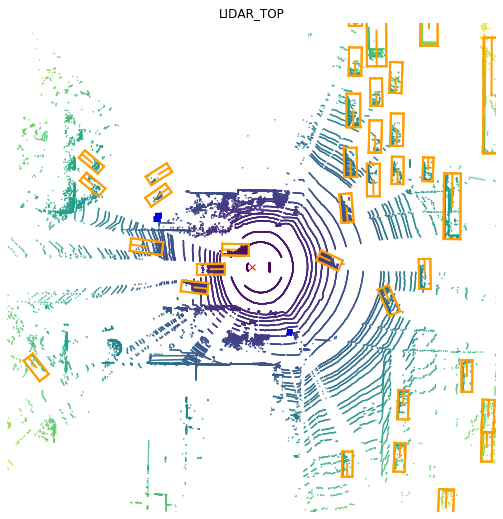

In [18]:
#level5data.render_scene(scene_token)


level5data.render_sample_data(sample['data']['LIDAR_TOP'], nsweeps=5)



In [29]:
## create database .pkl files

#TODO - create dummy ann files
#LYFT_TRAINVAL_DATASET_ROOT = '/home/itiv/Desktop/lyft-kaggle-dataset/test'
#!python Lyft-Detector/second.pytorch/second/create_data.py nuscenes_data_prep --root_path=$LYFT_TRAINVAL_DATASET_ROOT  --version="v1.0-test" --dataset_name="NuScenesDataset" --scene_token=$scene_token --max_sweeps=10
version = VERSION
!python Lyft-Detector/second.pytorch/second/create_data.py nuscenes_data_prep --root_path=$LYFT_DATASET_ROOT  --version=$version --dataset_name="NuScenesDataset" --scene_token=$scene_token --max_sweeps=10
##todo make this faster!!



/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environme

In [6]:
## set paths in config file...not necessary for detection generation but throws error if files are invalid...

config_path = CONFIG_FILE
#LYFT_TRAINVAL_DATASET_ROOT = '/home/itiv/Desktop/lyft-kaggle-dataset/train'
info_path = LYFT_DATASET_ROOT+'/infos_'+scene_token+'.pkl'

config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
config.train_input_reader.dataset.kitti_info_path = info_path
config.train_input_reader.dataset.kitti_root_path = LYFT_DATASET_ROOT

config.train_input_reader.preprocess.database_sampler.database_info_path = info_path
    
config.eval_input_reader.dataset.kitti_info_path = info_path
config.eval_input_reader.dataset.kitti_root_path = LYFT_DATASET_ROOT

config_text = text_format.MessageToString(config)
with open(config_path, "w") as f:
    f.write(config_text)

print('Paths set in config file')

Paths set in config file


In [31]:
##Perform detection


config_path = CONFIG_FILE
ckpt_path = MODEL_FILE
#info_path = LYFT_DATASET_ROOT+'/infos_'+scene_token+'.pkl'
root_path = LYFT_DATASET_ROOT
result_path = LYFT_DATASET_ROOT
print('Detecting...this might take several minutes...')
!python ./Lyft-Detector/second.pytorch/second/detect.py detect --scene_token=$scene_token --config_path=$config_path --ckpt_path=$ckpt_path --info_path=$info_path --root_path=$root_path --result_path=$result_path


print('############### Finished ###############')

Detecting...this might take several minutes...
/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/lyft_detector/lib/python3.6/site-packages/num

In [32]:
#Perform Tracking

root_path = LYFT_DATASET_ROOT
result_path = LYFT_DATASET_ROOT
version = VERSION
detection_file = result_path+'/detections_'+scene_token+'.json'
!python ./Lyft-Tracker/mahalanobis_3d_multi_object_tracking/main.py track --save_root=$root_path --version=$version --detection_file=$detection_file --data_root=$root_path

track nuscenes
Loading NuScenes tables for version v1.0-trainval...
9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 6.5 seconds.
Reverse indexing ...
Done reverse indexing in 2.3 seconds.
Loaded results from /home/itiv/Desktop/lyft-kaggle-dataset/train//detections_8b92f0eec8a8fd312adaa6bccb05c27f596e729d968202a9c223baf4a02e3a02.json. Found detections for 126 samples.
  0%|                                                   | 0/126 [00:00<?, ?it/s]./Lyft-Tracker/mahalanobis_3d_multi_object_tracking/main.py:116: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function roty failed at nopython mode lowering due to: 

File "Lyft-Tracker/mahalanobis_3d_multi_object_tracking/main.py", line 123:
def roty(t):
    <source elided>
                     [0,  1,  0],
                     [-s, 0,  c]

In [30]:
##create carmaker files...

### load track result dict
import json
import pandas as pd
from pyquaternion import Quaternion
import numpy as np
import math
import operator
from operator import add
from scipy.stats import beta
from collections import Counter


tracking_file = LYFT_DATASET_ROOT+'/tracking_results_'+scene_token+'.json'

with open(tracking_file) as json_file:
    data = json.load(json_file)

counter = 0

tracking_ids = []
sample_token = scene['first_sample_token']
timestamp = 0
for index in range(scene['nbr_samples']):
    sample = level5data.get('sample', sample_token)
    for detection_dict in data['results'][sample_token]:
        if not int(detection_dict['tracking_id']) in tracking_ids:
            tracking_ids.append(int(detection_dict['tracking_id']))
        else:
            counter += 1
    sample_token = sample['next']
    if sample_token is '':
        break

tracking_ids.sort()            
#print(tracking_ids)

print(f'Extracted {len(tracking_ids)} tracks')


index = range(scene['nbr_samples'])
columns = ["Car "+str(x) for x in tracking_ids]


traffic_coords = pd.DataFrame(index=index, columns=columns)
traffic_coords = traffic_coords.astype(object)

traffic_orientation = pd.DataFrame(index=index, columns=columns)
traffic_orientation = traffic_orientation.astype(object)

traffic_sizes = pd.DataFrame(index=index, columns=columns)
traffic_sizes = traffic_sizes.astype(object)

columns = ['Timestamp','Translation','Yaw']
ego_info = pd.DataFrame(index=index, columns=columns)
ego_info = ego_info.astype(object)


translation_offset = None

sample_token = scene['first_sample_token']
for index in range(scene['nbr_samples']):
    sample = level5data.get('sample', sample_token)
    sample_data = level5data.get('sample_data', sample['data']['LIDAR_TOP'])
    
    ego_pose = level5data.get('ego_pose', sample_data['ego_pose_token'])
    
    if translation_offset is None:
        translation_offset = ego_pose['translation']
    
    ego_info.at[index, 'Timestamp'] = ego_pose['timestamp']
    ego_info.at[index, 'Yaw'] = Quaternion(ego_pose['rotation']).yaw_pitch_roll[0]
    ego_info.at[index, 'Translation'] = list(map(operator.sub,ego_pose['translation'],translation_offset))
    #filter pedestrians and bicycles    
    for detection_dict in data['results'][sample_token]:
        if not (detection_dict['tracking_name'] == 'bicycle' or detection_dict['tracking_name'] == 'pedestrian'):
            traffic_coords.at[index, 'Car '+detection_dict['tracking_id']] =  list(map(operator.sub,detection_dict['translation'],translation_offset))
            traffic_orientation.at[index, 'Car '+detection_dict['tracking_id']] = Quaternion(detection_dict['rotation']).yaw_pitch_roll[0]
            traffic_sizes.at[index, 'Car '+detection_dict['tracking_id']] = detection_dict['size']
    sample_token = sample['next']
    if sample_token is '':
        break

#filter short occurence traffic <1s
for index,entrys in traffic_coords.count().iteritems():
    if entrys < 5:
        traffic_coords.drop(index,axis=1,inplace=True)
        traffic_sizes.drop(index,axis=1,inplace=True)
        traffic_orientation.drop(index,axis=1,inplace=True)
        
        
def dist(l1,l2):
    d = math.sqrt((l1[0]-l2[0])**2+(l1[1]-l2[1])**2+(l1[2]-l2[2])**2)
    return d
 
#filter intersection traffic with ego
for (columnName, columnData) in traffic_coords.iteritems():
    for index,item in enumerate(traffic_coords[columnName]):
        if type(ego_info.at[index, 'Translation']) is list and type(item) is list and dist(item,ego_info.at[index, 'Translation']) < 1:
            traffic_coords.drop(columnName,axis=1,inplace=True)
            traffic_sizes.drop(columnName,axis=1,inplace=True)
            traffic_orientation.drop(columnName,axis=1,inplace=True)
            print(f'dropped {columnName}')
        
        
#interpolate short NaNs
for (columnName, columnData) in traffic_coords.iteritems():
    for index,item in enumerate(traffic_coords[columnName]):
        if type(item) is list and len(traffic_coords[columnName])>index+1 and type(traffic_coords[columnName][index+1]) is not list:
            for step in range(10):
                if len(traffic_coords[columnName])>index+1+step and type(traffic_coords[columnName][index+1+step]) is list:
                    v = list(map(operator.sub, traffic_coords[columnName][index+1+step],item))
                    traffic_coords[columnName][index+1] = list(map(operator.add, item, [x / (step+1) for x in v]))
                    traffic_orientation[columnName][index+1] = (traffic_orientation[columnName][index+1+step]-traffic_orientation[columnName][index])/(step+1)
                    traffic_sizes[columnName][index+1] = traffic_sizes[columnName][index]
                    #print(f'{item} {traffic_coords[columnName][index+1]} {traffic_coords[columnName][index+1+step]}')
                    break




    
def plotVal(x):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy import stats
    plt.figure(figsize=(16, 6))
    sns.distplot(x);
    
    
#suppress random orientation changes 
#driving vehicle: orientation according to direction
#standing vehicle: orientation according to most detected

dt = 0.2 #Periodendauer
for (columnName, columnData) in traffic_orientation.iteritems():

    traffic_speed = []
    moving = False
    for index,item in enumerate(traffic_coords[columnName]):
        if type(item) is list and len(traffic_coords[columnName])>index+1 and type(traffic_coords[columnName][index+1]) is list:
            traffic_speed.append(abs(dist(item,traffic_coords[columnName][index+1])/dt))
        else:
            traffic_speed.append(np.nan)
    
    prev_orientation = None
    not_moving_orientations = []
    not_moving_start_index = 0
    for index,item in enumerate(traffic_speed):

        if moving and (abs(item) < 1.5 or math.isnan(item)):
            moving = False
            not_moving_orientations = []
            not_moving_start_index = index
        elif not moving and (abs(item) > 2 or math.isnan(item)): 
            if len(not_moving_orientations) > 1:
                orientation,_ = (Counter(not_moving_orientations).most_common(1)[0])
                if not math.isnan(orientation):
                    for idx in range(index-not_moving_start_index):
                        traffic_orientation[columnName][index-idx] = orientation
                
                #plotVal(not_moving_orientations)
            moving = True
        if not math.isnan(item):
            if index >= len(traffic_speed)-5:
                if prev_orientation is not None:
                    traffic_orientation[columnName][index] = prev_orientation
            elif moving and type(traffic_coords[columnName][index]) is list and type(traffic_coords[columnName][index+5]) is list:
                v = list(map(operator.sub,traffic_coords[columnName][index],traffic_coords[columnName][index+5]))
                yaw = math.atan2(v[1],v[0])-np.pi
                traffic_orientation[columnName][index] = yaw #---> TODO!!!!!!!!!!!!!!!!!!!!
            elif moving and type(traffic_coords[columnName][index]) is list and type(traffic_coords[columnName][index+1]) is not list and prev_orientation is not None:
                traffic_orientation[columnName][index] = prev_orientation
            elif not moving:
                not_moving_orientations.append(round(traffic_orientation[columnName][index],1))
                
            prev_orientation = traffic_orientation[columnName][index]
        else:
            traffic_orientation[columnName][index] = prev_orientation



print(traffic_coords)           
            

#max radian change:
''' dphi = math.pi/10
for (columnName, columnData) in traffic_orientation.iteritems():
    prev_orientation = None
    
    for index,item in enumerate(columnData.tolist()):
        if prev_orientation is None:
            prev_orientation = traffic_orientation.at[index, columnName]
            continue
        if not math.isnan(item):
            if abs(traffic_orientation.at[index, columnName]-prev_orientation) > math.pi:
                if(traffic_orientation.at[index, columnName]-prev_orientation > 0):
                    traffic_orientation.at[index, columnName] = prev_orientation-dphi
                else:
                    traffic_orientation.at[index, columnName] = prev_orientation+dphi
            elif abs(prev_orientation-traffic_orientation.at[index, columnName]) > dphi:
                if(traffic_orientation.at[index, columnName]-prev_orientation > 0):
                    traffic_orientation.at[index, columnName] = prev_orientation+dphi
                else:
                    traffic_orientation.at[index, columnName] = prev_orientation-dphi
            prev_orientation = traffic_orientation.at[index, columnName]
'''  

Extracted 67 tracks
                                                 Car 2  \
0    [-27.34466762411239, 17.467792817985128, 11.96...   
1    [-28.877857448639134, 18.388267403652208, 11.9...   
2    [-31.213078485744063, 19.45647282740265, 11.96...   
3    [-33.26485041332626, 20.733493481758842, 11.96...   
4    [-35.16623278159102, 21.698779876006256, 11.95...   
..                                                 ...   
121                                                NaN   
122                                                NaN   
123                                                NaN   
124                                                NaN   
125                                                NaN   

                                                 Car 3  \
0    [-13.904517038280119, -18.314062895275356, 10....   
1    [-13.821585149617704, -18.28465524218177, 10.8...   
2    [-13.862756988877663, -18.29080795756545, 10.7...   
3    [-13.835004447421852, -18.42040500278563, 10.8

' dphi = math.pi/10\nfor (columnName, columnData) in traffic_orientation.iteritems():\n    prev_orientation = None\n    \n    for index,item in enumerate(columnData.tolist()):\n        if prev_orientation is None:\n            prev_orientation = traffic_orientation.at[index, columnName]\n            continue\n        if not math.isnan(item):\n            if abs(traffic_orientation.at[index, columnName]-prev_orientation) > math.pi:\n                if(traffic_orientation.at[index, columnName]-prev_orientation > 0):\n                    traffic_orientation.at[index, columnName] = prev_orientation-dphi\n                else:\n                    traffic_orientation.at[index, columnName] = prev_orientation+dphi\n            elif abs(prev_orientation-traffic_orientation.at[index, columnName]) > dphi:\n                if(traffic_orientation.at[index, columnName]-prev_orientation > 0):\n                    traffic_orientation.at[index, columnName] = prev_orientation+dphi\n                else

In [31]:
## create result_json_dict

gt_dict = {'samples':[]}

#iterate over rows
for index, row in traffic_coords.iterrows():
    #iterate over columns
    sample_dict = {'token':'frame_'+str(index),'timestamp':index*0.2,'anns':[]}

    for colIndex in range(len(row)):
        if type(traffic_coords.iloc[index,colIndex]) is list:
            ann_dict = {'instance':colIndex,'translation':traffic_coords.iloc[index,colIndex],'size':traffic_sizes.iloc[index,colIndex],'rotation':traffic_orientation.iloc[index,colIndex]}
            sample_dict['anns'].append(ann_dict)
    gt_dict['samples'].append(sample_dict)

print(gt_dict)


{'samples': [{'token': 'frame_0', 'timestamp': 0.0, 'anns': [{'instance': 0, 'translation': [-27.34466762411239, 17.467792817985128, 11.9611297366637], 'size': [3.176335096359253, 11.641521453857422, 3.2270781993865967], 'rotation': -3.6324064857384584}, {'instance': 1, 'translation': [-13.904517038280119, -18.314062895275356, 10.883358131502247], 'size': [1.965244174003601, 4.975393295288086, 1.6623908281326294], 'rotation': -0.5442445322867027}, {'instance': 2, 'translation': [-8.476065392757164, -2.8997615997498087, 10.930325923031146], 'size': [1.9214099645614624, 4.6968183517456055, 1.6390745639801025], 'rotation': -3.687758014748222}, {'instance': 3, 'translation': [14.191990113231213, -8.444147387069734, 11.003987946235998], 'size': [1.9572210311889648, 4.752435684204102, 1.6462823152542114], 'rotation': -3.6923556616879782}, {'instance': 4, 'translation': [-32.86545993379468, 24.413491008988785, 10.721559475216589], 'size': [1.9381790161132812, 4.7507853507995605, 1.62730956077

In [32]:
##create CarMaker Files...
import os
import random
        
def dist(l1,l2):
    d = math.sqrt((l1[0]-l2[0])**2+(l1[1]-l2[1])**2+(l1[2]-l2[2])**2)
    return d

CM_PROJECT_DIR =  LYFT_DATASET_ROOT+'/CarMaker'#'C://CM_Projects//maneuver_simu'
TESTRUN_DIR = CM_PROJECT_DIR+'/TestRun'#CM_PROJECT_DIR+'//Data//TestRun'
SIMINPUT_DIR = CM_PROJECT_DIR+'/SimInput/'#CM_PROJECT_DIR+'//SimInput'

GROUND_TRUTH_DIR = CM_PROJECT_DIR+'/gt_data/'  #only for eval

if not os.path.exists(CM_PROJECT_DIR):
    os.mkdir(CM_PROJECT_DIR)
if not os.path.exists(TESTRUN_DIR):
    os.mkdir(TESTRUN_DIR)
if not os.path.exists(SIMINPUT_DIR):
    os.mkdir(SIMINPUT_DIR)
if not os.path.exists(GROUND_TRUTH_DIR):
    os.mkdir(GROUND_TRUTH_DIR)
    

TESTRUN_ID = 'scene-'+str(SCENE_NUM)+'-'+MODEL
TESTRUN_NAME = f'//testrun_{TESTRUN_ID}'
TESTRUN_PATH = TESTRUN_DIR+TESTRUN_NAME
TRAFFIC_PROFILE_NAME = f'traffic_profile_{TESTRUN_ID}.txt'
TRAFFIC_PROFILE_PATH = SIMINPUT_DIR+TRAFFIC_PROFILE_NAME
EGO_PROFILE_NAME = f'ego_profile_{TESTRUN_ID}.txt'
EGO_PROFILE_PATH = SIMINPUT_DIR+EGO_PROFILE_NAME

gt_data_name = f'gt_data_{TESTRUN_ID}.json'
with open(GROUND_TRUTH_DIR+gt_data_name, 'w') as fp:
    json.dump(gt_dict, fp)



content_lines = []
content_lines.append('#INFOFILE1.1 - Do not remove this line!\n\
FileIdent = CarMaker-TestRun 8\n\
FileCreator = CarMaker 8.1 2019-11-07\n\
Description:\n\
Vehicle = UserVehicle_MyCar\n\
Trailer =\n\
Tire.0 =\n\
Tire.1 =\n\
Tire.2 =\n\
Tire.3 =\n\
Snapshot.TimeLimit =\n\
Snapshot.DistLimit =\n\
VehicleLoad.0.mass = 0\n\
VehicleLoad.0.pos = 0 0 0\n\
VehicleLoad.1.mass = 0\n\
VehicleLoad.1.pos = 0 0 0\n\
VehicleLoad.2.mass = 0\n\
VehicleLoad.2.pos = 0 0 0\n\
VehicleLoad.3.mass = 0\n\
VehicleLoad.3.pos = 0 0 0\n\
TrailerLoad.0.mass = 0\n\
TrailerLoad.0.pos = 0 0 0\n\
TrailerLoad.1.mass = 0\n\
TrailerLoad.1.pos = 0 0 0\n\
TrailerLoad.2.mass = 0\n\
TrailerLoad.2.pos = 0 0 0\n')
                     
#ego maneuver for every 10th coord

time_between_records = 0.2 

start_vel = 0#ego_vel[0]
man_counter = 1
#ego_man = []
#for vel in ego_vel[::10]:
#    ego_man.append('DrivMan.'+str(man_counter)+'.TimeLimit = '+str(10*time_between_records)+'\n\
#DrivMan.'+str(man_counter)+'.LongDyn = VelControl '+str(vel*3.6)+' 0.0 1.0 0 1 0\n\
#DrivMan.'+str(man_counter)+'.LatDyn = Driver 0\n')
#    man_counter += 1
    
       # +str(start_vel)+
content_lines.append('DrivMan.Init.Velocity = 0\n\
DrivMan.Init.SteerAng = 0\n\
DrivMan.Init.GearNo = 0\n\
DrivMan.Init.LaneOffset = 0\n\
DrivMan.Init.OperatorActive = 1\n\
DrivMan.Init.OperatorState = drive\n\
DrivMan.VhclOperator.Kind = IPGOperator 1\n\
DrivMan.nDMan = '+str(man_counter)+'\n')

content_lines.append('DrivMan.0.TimeLimit = '+str(time_between_records*(len(ego_info)-1))+'\n\
DrivMan.0.LongDyn = Stop 2.0 0\n\
DrivMan.0.LatDyn = Driver 0\n')


#write traffic profile file

traffic_profile = []
traffic_profile.append('# Time')
for index,col in enumerate(traffic_coords):
    traffic_profile.append(' FM_tx_%d FM_ty_%d FM_tz_%d FM_rz_%d' % (index,index,index,index))
traffic_profile.append('\n')    


prev_row = None
for time_index, row in traffic_coords.iterrows():
    traffic_profile.append('%f'%(time_index*time_between_records))

    for car_index,coords in enumerate(row):
        if type(coords) is list:
            traffic_profile.append(' %f %f %f %f'%(coords[0],coords[1],0.6,traffic_orientation.iloc[time_index,car_index]))
        else:
            traffic_profile.append(' %f %f %f %f'%(0,0,-100,0))
    
    prev_row = row
    traffic_profile.append('\n') 
    

    
with open(TRAFFIC_PROFILE_PATH, 'w') as f:
    for item in traffic_profile:
        f.write("%s" % item)


traffic_counter = 0   
traffic_counter = len(traffic_coords.columns)
content_lines.append('Traffic.IFF.FName = SimInput/'+TRAFFIC_PROFILE_NAME+'\n\
Traffic.IFF.Time.Name = Time\n\
Traffic.N = %d\n\
Traffic.SpeedUnit = ms\n'%traffic_counter)


#get average sizes of vehicle

traffic_sizes_avr = []
for (columnName, columnData) in traffic_sizes.iteritems():
    counter = 0
    l_sum = 0
    for size in columnData.values:
        if isinstance(size, list):
            counter += 1
            l_sum += size[1]
    traffic_sizes_avr.append(l_sum/counter)

small_car = ['Audi_TT_2015.mobj','Citroen_C3_2015.mobj','Honda_Fit_2015.mobj'] #l<4m
medium_car = ['Audi_A4AllRoad_2016.mobj','Audi_A7_2018.mobj','BMW_5_2017.mobj','Honda_CivicTypeR_2018.mobj','MB_AClass_2018.mobj','MB_CClass_2015.mobj','Jaguar_FType_2017.mobj'] #l<5m
large_car = ['Chevrolet_Silverado1500_2013.mobj','Chrysler_Pacifica_2016.mobj','Dodge_GrandCaravan_2011.mobj','LandRover_RangeRover_2014.mobj','MB_XClass_2018.mobj'] #l<6m
van = ['Ford_Transit_2014.mobj','MB_Sprinter_2013.mobj','MB_Vito_2014.mobj','VW_T6_2016.mobj','VW_Transporter_2016.mobj'] #l<10m
bus_truck = ['Coach.mobj','Euro_ConcreteMixer.mobj','Iveco_EurotechLN2_1992.mobj','MAN_TGS_2012.mobj','MB_Actros_1996.mobj','MB_Atego_2013_Move.mobj'] #l>10m
    
    

for index,col in enumerate(traffic_coords): 
    
    vehicle_path = '3D/Vehicles/'
    
    if traffic_sizes_avr[index]<4:
        vehicle_path = vehicle_path+small_car[random.randrange(0,len(small_car),1)]
    elif traffic_sizes_avr[index]<5:
        vehicle_path = vehicle_path+medium_car[random.randrange(0,len(medium_car),1)]
    elif traffic_sizes_avr[index]<6:
        vehicle_path = vehicle_path+large_car[random.randrange(0,len(large_car),1)]
    elif traffic_sizes_avr[index]<10:
        vehicle_path = vehicle_path+van[random.randrange(0,len(van),1)]   
    elif traffic_sizes_avr[index]>10:
        vehicle_path = vehicle_path+bus_truck[random.randrange(0,len(bus_truck),1)]   

    content_lines.append('Traffic.'+str(index)+'.ObjectKind = Movable\n\
Traffic.'+str(index)+'.ObjectClass = Car\n\
Traffic.'+str(index)+'.Name = T'+str(index)+'\n\
Traffic.'+str(index)+'.Info = UNNAMED Object '+str(index)+'\n\
Traffic.'+str(index)+'.Movie.Geometry = '+vehicle_path+'\n\
Traffic.'+str(index)+'.Color = 1.0 0.0 0.0\n\
Traffic.'+str(index)+'.Basics.Dimension = 4.28 1.82 1.28\n\
Traffic.'+str(index)+'.Basics.Offset = 0.0 0.0\n\
Traffic.'+str(index)+'.Basics.Fr12CoM = 2.15\n\
Traffic.'+str(index)+'.Init.Orientation = 0.0 0.0 0.0\n\
Traffic.'+str(index)+'.RCSClass = RCS_Car\n\
Traffic.'+str(index)+'.DetectMask = 1 1\n\
Traffic.'+str(index)+'.Route = 0 1\n\
Traffic.'+str(index)+'.Init.Road = 18 R2\n\
Traffic.'+str(index)+'.Init.v = 1\n\
Traffic.'+str(index)+'.FreeMotion = 1\n\
Traffic.'+str(index)+'.UpdRate = 200\n\
Traffic.'+str(index)+'.IFF.FM_tx.Name =FM_tx_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_tx.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_tx.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_ty.Name =FM_ty_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_ty.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_ty.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_tz.Name =FM_tz_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_tz.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_tz.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_rx.Name =\n\
Traffic.'+str(index)+'.IFF.FM_rx.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_rx.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_ry.Name =\n\
Traffic.'+str(index)+'.IFF.FM_ry.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_ry.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_rz.Name =FM_rz_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_rz.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_rz.Offset = 0.0\n')

    
ego_coords = ego_info['Translation'].tolist()





road_points = []

prev_row = None
distance = 5.5
for index,row in enumerate(ego_coords[::1]):  
    if prev_row is None or abs(dist([row[0],row[1],0],prev_row))>1 :
        dx = -1*math.sin(ego_info.at[index, 'Yaw'])*distance
        dy = math.cos(ego_info.at[index, 'Yaw'])*distance
        road_points.append([row[0]+dx,row[1]+dy])
        prev_row=[row[0],row[1],0]
        
        
        
#pointlist start degree
dx = road_points[1][0]-road_points[0][0]
dy = road_points[1][1]-road_points[0][1]

startDeg = math.degrees(math.atan2(dx, dy))


#pointlist end vector
dx = ego_coords[-1][0]-ego_coords[-2][0]
dy = ego_coords[-1][1]-ego_coords[-2][1]

content_lines.append('DrivMan.OW.Active = 1\n\
DrivMan.OW.Quantities = Time User1 User2 User3 User4\n\
DrivMan.OW.StartGearNo = 1\n\
DrivMan.OW.StartVelocity =\n\
DrivMan.OW.GasMax = 0.5\n\
DrivMan.OW.RefCh = Time\n\
DrivMan.OW.ConsiderRoadSigns = 0\n\
DrivMan.OW.sRoute.Offset = 0\n\
DrivMan.OW.Time.Name = t[s]\n\
DrivMan.OW.Time.Factor = 1.0\n\
DrivMan.OW.User1.Name = x\n\
DrivMan.OW.User1.Factor = 1.0\n\
DrivMan.OW.User1.Offset = 0.0\n\
DrivMan.OW.User2.Name = y\n\
DrivMan.OW.User2.Factor = 1.0\n\
DrivMan.OW.User2.Offset = 0.0\n\
DrivMan.OW.User3.Name = yaw\n\
DrivMan.OW.User3.Factor = 1.0\n\
DrivMan.OW.User3.Offset = 0.0\n\
DrivMan.OW.User4.Name = -\n\
DrivMan.OW.User4.Factor = 1.0\n\
DrivMan.OW.User4.Offset = 0.0\n\
DrivMan.OW.FName = '+EGO_PROFILE_NAME+'\n\
ErrorClass.0.Action = abort\n\
ErrorClass.0.Save = 0\n\
ErrorClass.0.WarningLimit = 3 5\n\
ErrorClass.1.Action = abort\n\
ErrorClass.1.Save = 0\n\
ErrorClass.1.WarningLimit = 3 5\n\
ErrorClass.2.Action = abort\n\
ErrorClass.2.Save = 0\n\
ErrorClass.2.WarningLimit = 3 5\n\
ErrorClass.3.Action = abort\n\
ErrorClass.3.Save = 0\n\
ErrorClass.3.WarningLimit = 3 5\n\
ErrorClass.4.Action = abort\n\
ErrorClass.4.Save = 0\n\
ErrorClass.4.WarningLimit = 3 5\n\
ErrorClass.5.Action = abort\n\
ErrorClass.5.Save = 0\n\
ErrorClass.5.WarningLimit = 3 5\n\
ErrorClass.6.Action = abort\n\
ErrorClass.6.Save = 0\n\
ErrorClass.6.WarningLimit = 10 5\n\
ErrorClass.7.Action = abort\n\
ErrorClass.7.Save = 0\n\
ErrorClass.7.WarningLimit = 3 5\n\
ErrorClass.10.Action = abort\n\
ErrorClass.10.Save = 0\n\
ErrorClass.10.WarningLimit = 3 5\n\
ErrorClass.11.Action = abort\n\
ErrorClass.11.Save = 0\n\
ErrorClass.11.WarningLimit = 3 5\n\
Road.FileIdent = IPGRoad 8.0\n\
Road.LibVersion = 8.1\n\
Road.Country = DEU\n\
Road.nLinks = 1\n\
Road.nJunctions = 0\n\
Road.nObjects = 149\n\
Road.nRoutes = 1\n\
Road.RoadNetworkLength = 595.296984550432\n\
Road.BBox = -19.5668198180623 547.415304391587 -224.837648089968 34.6179698226834 -11 11\n\
Road.Route.0.Length = 595.296984550432\n\
Road.RST.Unit = kmh\n\
Road.RST = 50 100 130 30 70 30 0 -1\n\
Road.Movie = 0.2 1 0.01 1.5 1.5 1 1\n\
Road.PathMode = -1\n\
Road.Link.0.ID = 0\n\
Road.Link.0.Junctions = -1 -1 -2 -1\n\
Road.Link.0.Node0 = 0 0 0 '+str(startDeg)+'\n\
Road.Link.0.RST = countryroad\n\
Road.Link.0.RL.ID = 1\n\
Road.Link.0.Seg.0.ID = 5\n\
Road.Link.0.Seg.0.Type = PointList\n\
Road.Link.0.Seg.0.Param =  '+str(dx)+' '+str(dy)+' 1 0 0 0 0 0\n\
Road.Link.0.Seg.0.PointList:\n')

#append road pointlist
obj_id=5
pointlist = []
pointlist.append('# t[s] x y yaw -\n')
counter = 0
for index,row in enumerate(ego_coords[::1]):
    pointlist.append('  %f %f %f %f %f\n'%(counter*time_between_records,row[0],row[1],ego_info.at[index, 'Yaw'],0))
    counter += 1

    
with open(EGO_PROFILE_PATH, 'w') as f:
    for item in pointlist:
        f.write("%s" % item)
        
        
pointlist = ''

        
        
##extending road
d0 = 500 #road extension distance


# at the end
#m = (road_points[-1][1]-road_points[-2][1])/(road_points[-1][0]-road_points[-2][0])
dx = road_points[-2][0]-road_points[-1][0]#dx = d0/math.sqrt(1+m**2)
dy = road_points[-2][1]-road_points[-1][1]#dy = m*dx
road_points.append([road_points[-1][0]-dx*100,road_points[-1][1]-dy*100])

# at the beginning
#m = (road_points[0][1]-road_points[1][1])/(road_points[0][0]-road_points[1][0])
dx = road_points[0][0]-road_points[1][0]#d0/math.sqrt(1+m**2)
dy = road_points[0][1]-road_points[1][1]#m*dx
#road_points = [[road_points[0][0]+dx*100,road_points[0][1]+dy*100]] + road_points
    
for row in road_points:
    obj_id +=  1
    pointlist = pointlist + '	'+str(row[0])+' '+str(row[1])+'\n'
    
content_lines.append(pointlist)    
    
content_lines.append('Road.Link.0.LaneSection.0.ID = '+str(obj_id+1)+'\n\
Road.Link.0.LaneSection.0.Start = 0\n\
Road.Link.0.LaneSection.0.LaneL.0.ID = '+str(obj_id+2)+'\n\
Road.Link.0.LaneSection.0.LaneL.0 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.0.ARP = '+str(obj_id+5)+' '+str(obj_id+6)+' '+str(obj_id+7)+' '+str(obj_id+8)+' '+str(obj_id+9)+' '+str(obj_id+10)+'\n\
Road.Link.0.LaneSection.0.LaneL.1.ID = '+str(obj_id+13)+'\n\
Road.Link.0.LaneSection.0.LaneL.1 = 0 0.75 0.75 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.1.ARP = '+str(obj_id+16)+' '+str(obj_id+17)+' '+str(obj_id+18)+' '+str(obj_id+19)+' '+str(obj_id+20)+' '+str(obj_id+21)+'\n\
Road.Link.0.LaneSection.0.LaneL.2.ID = '+str(obj_id+24)+'\n\
Road.Link.0.LaneSection.0.LaneL.2 = 0 1.5 1.5 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.2.ARP = '+str(obj_id+27)+' '+str(obj_id+28)+' '+str(obj_id+29)+' '+str(obj_id+30)+' '+str(obj_id+31)+' '+str(obj_id+32)+'\n\
Road.Link.0.LaneSection.0.LaneL.3.ID = '+str(obj_id+34)+'\n\
Road.Link.0.LaneSection.0.LaneL.3 = 0 1.5 1.5 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.3.ARP = '+str(obj_id+37)+' '+str(obj_id+38)+' '+str(obj_id+39)+' '+str(obj_id+40)+' '+str(obj_id+41)+' '+str(obj_id+51)+'\n\
Road.Link.0.LaneSection.0.LaneL.4.ID = '+str(obj_id+44)+'\n\
Road.Link.0.LaneSection.0.LaneL.4 = 0 0.75 0.75 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.4.ARP = '+str(obj_id+47)+' '+str(obj_id+48)+' '+str(obj_id+49)+' '+str(obj_id+50)+' '+str(obj_id+51)+' '+str(obj_id+52)+'\n\
Road.Link.0.LaneSection.0.LaneL.5.ID = '+str(obj_id+55)+'\n\
Road.Link.0.LaneSection.0.LaneL.5 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.5.ARP = '+str(obj_id+58)+' '+str(obj_id+59)+' '+str(obj_id+60)+' '+str(obj_id+61)+' '+str(obj_id+62)+' '+str(obj_id+63)+'\n\
Road.Link.0.LaneSection.0.LaneL.6.ID = '+str(obj_id+66)+'\n\
Road.Link.0.LaneSection.0.LaneL.6 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.6.ARP = '+str(obj_id+69)+' '+str(obj_id+70)+' '+str(obj_id+71)+' '+str(obj_id+72)+' '+str(obj_id+73)+' '+str(obj_id+74)+'\n\
Road.Link.0.LaneSection.0.LaneL.7.ID = '+str(obj_id+77)+'\n\
Road.Link.0.LaneSection.0.LaneL.7 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.7.ARP = '+str(obj_id+80)+' '+str(obj_id+81)+' '+str(obj_id+82)+' '+str(obj_id+83)+' '+str(obj_id+84)+' '+str(obj_id+85)+'\n\
Road.Link.0.LaneSection.0.LaneL.8.ID = '+str(obj_id+88)+'\n\
Road.Link.0.LaneSection.0.LaneL.8 = 0 1 1 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.8.ARP = '+str(obj_id+91)+' '+str(obj_id+92)+' '+str(obj_id+93)+' '+str(obj_id+94)+' '+str(obj_id+95)+' '+str(obj_id+96)+'\n\
Road.Link.0.LaneSection.0.LaneL.9.ID = '+str(obj_id+98)+'\n\
Road.Link.0.LaneSection.0.LaneL.9 = 0 2.5 2.5 5 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.0.ID = '+str(obj_id+101)+'\n\
Road.Link.0.LaneSection.0.LaneR.0 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.0.ARP = '+str(obj_id+104)+' '+str(obj_id+105)+' '+str(obj_id+106)+' '+str(obj_id+107)+' '+str(obj_id+108)+' '+str(obj_id+109)+'\n\
Road.Link.0.LaneSection.0.LaneR.1.ID = '+str(obj_id+112)+'\n\
Road.Link.0.LaneSection.0.LaneR.1 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.1.ARP = '+str(obj_id+115)+' '+str(obj_id+116)+' '+str(obj_id+117)+' '+str(obj_id+118)+' '+str(obj_id+119)+' '+str(obj_id+120)+'\n\
Road.Link.0.LaneSection.0.LaneR.2.ID = '+str(obj_id+123)+'\n\
Road.Link.0.LaneSection.0.LaneR.2 = 0 1 1 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.2.ARP = '+str(obj_id+126)+' '+str(obj_id+127)+' '+str(obj_id+128)+' '+str(obj_id+129)+' '+str(obj_id+130)+' '+str(obj_id+131)+'\n\
Road.Link.0.LaneSection.0.LaneR.3.ID = '+str(obj_id+133)+'\n\
Road.Link.0.LaneSection.0.LaneR.3 = 0 2.5 2.5 5 0 0 0\n\
Road.LanePath.0 = '+str(obj_id+11)+' '+str(obj_id+2)+' 2 10 0.1 0.1\n\
Road.LanePath.1 = '+str(obj_id+22)+' '+str(obj_id+13)+' 0.25 10 0.1 0.1\n\
Road.LanePath.2 = '+str(obj_id+33)+' '+str(obj_id+24)+' 0.25 10 0.1 0.1\n\
Road.LanePath.3 = '+str(obj_id+43)+' '+str(obj_id+34)+' 0.25 10 0.1 0.1\n\
Road.LanePath.4 = '+str(obj_id+53)+' '+str(obj_id+44)+' 0.25 10 0.1 0.1\n\
Road.LanePath.5 = '+str(obj_id+64)+' '+str(obj_id+55)+' 2 10 0.1 0.1\n\
Road.LanePath.6 = '+str(obj_id+75)+' '+str(obj_id+66)+' 2 10 0.1 0.1\n\
Road.LanePath.7 = '+str(obj_id+86)+' '+str(obj_id+77)+' 2 10 0.1 0.1\n\
Road.LanePath.8 = '+str(obj_id+97)+' '+str(obj_id+88)+' 0.25 10 0.1 0.1\n\
Road.LanePath.9 = '+str(obj_id+110)+' '+str(obj_id+101)+' 2 10 0.1 0.1\n\
Road.LanePath.10 = '+str(obj_id+121)+' '+str(obj_id+112)+' 2 10 0.1 0.1\n\
Road.LanePath.11 = '+str(obj_id+132)+' '+str(obj_id+123)+' 0.25 10 0.1 0.1\n\
Route.0.ID = '+str(obj_id+137)+'\n\
Route.0.Name = Route_0\n\
Route.0.DrvPath.ID = '+str(obj_id+138)+'\n\
Route.0.DrvPath:\n\
	'+str(obj_id+110)+'\n\
Road.RL.1.RoadMarking.0.ID = '+str(obj_id+136)+' '+str(obj_id+1)+'\n\
Road.RL.1.RoadMarking.0 = 0 0 0 1 0 0 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.0.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.1.ID = '+str(obj_id+122)+' '+str(obj_id+112)+'\n\
Road.RL.1.RoadMarking.1 = 0 0 0 1 0 -1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.1.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.2.ID = '+str(obj_id+111)+' '+str(obj_id+101)+'\n\
Road.RL.1.RoadMarking.2 = 0 0 0 1 0 -1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.2.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.3.ID = '+str(obj_id+87)+' '+str(obj_id+77)+'\n\
Road.RL.1.RoadMarking.3 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.3.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.4.ID = '+str(obj_id+76)+' '+str(obj_id+66)+'\n\
Road.RL.1.RoadMarking.4 = 0 0 0 1 0 1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.4.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.5.ID = '+str(obj_id+65)+' '+str(obj_id+55)+'\n\
Road.RL.1.RoadMarking.5 = 0 0 0 1 0 1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.5.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.6.ID = '+str(obj_id+54)+' '+str(obj_id+44)+'\n\
Road.RL.1.RoadMarking.6 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.6.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.7.ID = '+str(obj_id+23)+' '+str(obj_id+13)+'\n\
Road.RL.1.RoadMarking.7 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.7.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.8.ID = '+str(obj_id+12)+' '+str(obj_id+2)+'\n\
Road.RL.1.RoadMarking.8 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.8.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.MaxUsedObjId = '+str(obj_id+150)+'\n\
Road.VhclStartPos = 0 0 0\n\
Road.VhclRoute = Route_0\n\
Road.RouteId = 0\n\
Env.StartTime.Year = 2019\n\
Env.StartTime.Month = 1\n\
Env.StartTime.Day = 1\n\
Env.StartTime.Hour = 12\n\
Env.StartTime.Min = 0\n\
Env.StartTime.Sec = 0\n\
Env.StartTime.DeltaUTC = 0.0\n\
Env.GNav.Active = 0\n\
Env.Temperature = 20.0\n\
Env.AirDensity = 1.205\n\
Env.AirPressure = 1.013\n\
Env.AirHumidity = 60\n\
Env.SolarRadiation = 400.0\n\
Env.RainRate = 0.0\n\
Env.VisRangeInFog = 1000.0\n\
Env.Wind.Kind = none\n\
Env.Wind.Velocity = 0.0\n\
Env.Wind.Angle = 0.0\n\
Env.Sun.Position = geographicDefinition\n\
Env.Sun.Azimuth = 180.0\n\
Env.Sun.Elevation = 45.0\n\
Env.Kind = Generic\n\
Env.Temp.Offset_Elev = -0.0065\n\
Env.Temp.Offset_sRoad.Amplify = 1.0\n\
Env.Temp.Offset_sRoad.On = 0\n\
Env.Temp.Offset_Time.Amplify = 1.0\n\
Env.Temp.Offset_Time.On = 1\n\
Env.Temp.Offset_Time:\n\
	0.0 -2.0\n\
	3.0 -2.5\n\
	6.0 -2.7\n\
	7.5 -2.7\n\
	9.0 -2.5\n\
	10.0 -2.3\n\
	11.0 -1.6\n\
	12.0 0.0\n\
	13.0 1.4\n\
	14.0 2.1\n\
	15.5 2.5\n\
	17.0 2.2\n\
	18.0 1.7\n\
	19.0 1.1\n\
	20.0 0.2\n\
	21.0 -0.6\n\
	22.0 -1.1\n\
	23.0 -1.6\n\
	24.0 -2.0\n\
Driver.ParamIdent = IPGDriver 5\n\
Driver.Mode = std\n\
Driver.Long.DrivMaxSpeed = 0\n\
Driver.Long.CruisingSpeed = 150\n\
Driver.CornerCutCoef = 0.5\n\
Driver.ConsiderTraffic = 1\n\
Driver.Traffic.TimeGapMin = 1.8\n\
Driver.Traffic.TimeGapMax = 5.0\n\
Driver.Traffic.DistMin = 6\n\
Driver.Traffic.DistMax = 250\n\
Driver.Traffic.EcoCoef = 0.75\n\
Driver.Traffic.Overtake = 0\n\
Driver.Traffic.Overtake_Rate = 1\n\
Driver.Traffic.Overtake_dSpeedMin = 10\n\
Driver.Long.dtAccBrake = 0.5\n\
Driver.Long.axMax = 3.0\n\
Driver.Long.axMin = -4.0\n\
Driver.Long.ayMax = 4.0\n\
Driver.Long.GGExp:\n\
	50 1.0 1.0\n\
Driver.Long.DevMax = 0.0\n\
Driver.Long.tReact = 0.0\n\
Driver.Long.TractionControl = 1\n\
Driver.DecShift.UseBrakePark = 0\n\
Driver.DecShift.tSwitchGear = 1.0\n\
Driver.DecShift.nEngine.Limits:\n\
	1500 4000\n\
Driver.DecShift.nEngine.Shift:\n\
	2000 3000\n\
Driver.Lat.DevMax = 0.0\n\
Driver.Lat.tReact = 0.0\n\
Driver.Knowl.Long.tActionMin = 4\n\
Driver.Knowl.Lat.StWhlAngleMax = 630\n\
Driver.Knowl.Lat.StWhlAngleVelMax = 500\n\
Driver.Knowl.Lat.StWhlAngleAccMax = 3000\n\
Driver.Learn.VehicleLimits.TestRun =\n\
Driver.Learn.VehicleLimits.Date = 0\n\
Driver.Learn.ControllerDyn.TestRun =\n\
Driver.Learn.ControllerDyn.Date = 0\n\
Driver.Learn.MaxSpeed.TestRun =\n\
Driver.Learn.MaxSpeed.Date = 0\n\
Driver.Learn.Remember = 0\n\
Driver.Learn.Friction = 1.0\n\
Driver.Knowl.Long.tPreviewBra = 0.6\n\
Driver.Knowl.Long.tPreviewAcc = 1.5\n\
Driver.Knowl.Lat.tPreview = 0.8\n\
Driver.Learn.NEng_S = 1\n')


with open(TESTRUN_PATH, 'w') as f:
    for item in content_lines:
        f.write("%s" % item)
        
print(f'Saved files to: {TESTRUN_PATH}')

Saved files to: /home/itiv/Desktop/lyft-kaggle-dataset/train//CarMaker/TestRun//testrun_scene-106-final


In [25]:
import os
from shutil import copyfile

## optional create video from camera data
#temp_path = LYFT_DATASET_ROOT+'/temp'
#if not os.path.exists(temp_path):
#    os.mkdir(temp_path)

img_list = []

sample_token = scene['first_sample_token']
counter = 0
while sample_token is not '':
    sample = level5data.get('sample', sample_token)
    sample_data = level5data.get('sample_data', sample['data']['CAM_FRONT'])
    img_list.append('file '+LYFT_DATASET_ROOT+sample_data['filename'])
    #copyfile(LYFT_DATASET_ROOT+sample_data['filename'],temp_path+'/img_'+str(counter)+'.jpeg')
    counter += 1
    sample_token = sample['next']

    
img_list_path = LYFT_DATASET_ROOT+'/img_list.txt'
video_path = LYFT_DATASET_ROOT+'CarMaker/video-'+TESTRUN_ID+'.mp4'
with open(img_list_path, 'w') as f:
    for item in img_list:
        f.write("%s\n" % item)
    
!ffmpeg -f concat -r 5 -safe 0 -i $img_list_path -r 5 -c:v libx264 -pix_fmt yuv420p $video_path
    
print('Video saved to: '+video_path)

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

Video saved to: /home/itiv/Desktop/lyft-kaggle-dataset/train/CarMaker/video-scene-0-final.mp4
